# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion).

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1]
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(f"Device = {device}, dtype = {dtype}")

Device = cuda, dtype = torch.float32


# 1) Data Processing

<KeysViewHDF5 ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']>
T_mesh:  torch.Size([100, 1])
X_mesh:  torch.Size([128, 1])
A_test:  torch.Size([200, 128])
U_test:  torch.Size([200, 100, 128])
A_train:  torch.Size([1000, 128])
U_train:  torch.Size([1000, 100, 128])


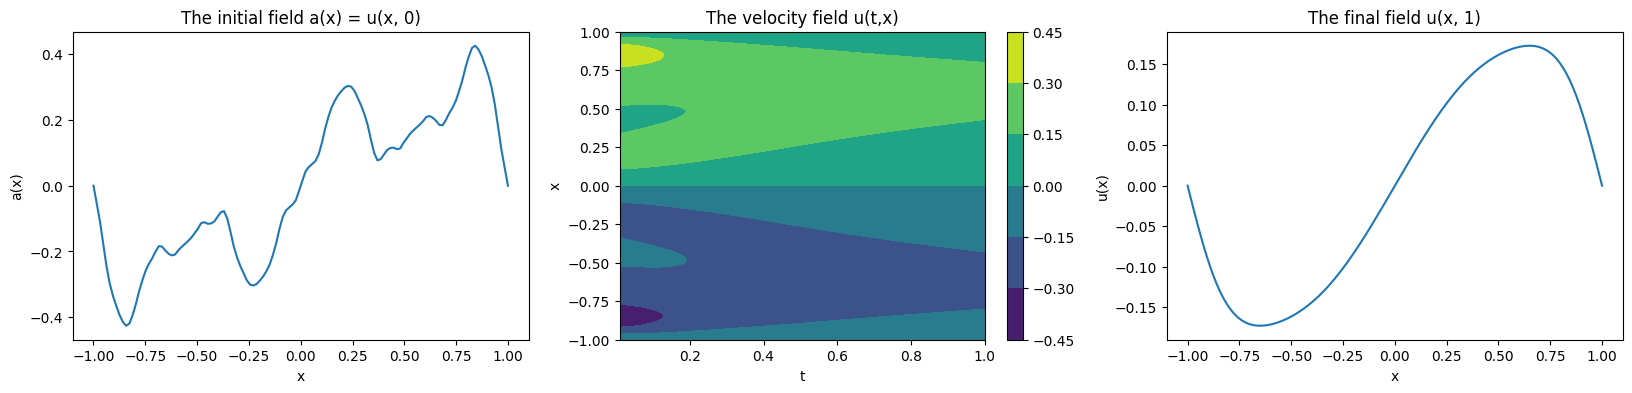

In [2]:
######################################
# Load training data
######################################
with h5py.File('TrafficFlow.h5', 'r') as file:
    print(file.keys())
    t_mesh = torch.tensor(np.array(file['t_mesh']), dtype=dtype).to(device)
    x_mesh = torch.tensor(np.array(file['x_mesh']), dtype=dtype).to(device)
    a_test = torch.tensor(np.array(file['a_test']), dtype=dtype).to(device)
    u_test = torch.tensor(np.array(file['u_test']), dtype=dtype).to(device)
    a_train = torch.tensor(np.array(file['a_train']), dtype=dtype).to(device)
    u_train = torch.tensor(np.array(file['u_train']), dtype=dtype).to(device)
    #
    X, T = np.meshgrid(x_mesh.cpu(), t_mesh.cpu())
#
print("T_mesh: ", t_mesh.shape)
print("X_mesh: ", x_mesh.shape)
print("A_test: ", a_test.shape)
print("U_test: ", u_test.shape)
print("A_train: ", a_train.shape)
print("U_train: ", u_train.shape)
#################################
inx = 100
fig, axes = plt.subplots(1,3, figsize=(20,4))
#
cntr = axes[0].plot(x_mesh.cpu(), a_train[inx].cpu())
axes[0].set_title('The initial field a(x) = u(x, 0)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('a(x)')
#
cntr = axes[1].contourf(T, X, u_train[inx].cpu())
axes[1].set_title('The velocity field u(t,x)')
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
plt.colorbar(cntr)
#
cntr = axes[2].plot(x_mesh.cpu(), u_train[inx][-1].cpu())
axes[2].set_title('The final field u(x, 1)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('u(x)')
plt.show()


# For this scenario, either choice between (x, t) or (t, x) is plausible
# The following code used (x, t), for (t, x) the commented lines need to be changed


### FOR TRAINING DATA ###

a_ext = a_train.unsqueeze(2).unsqueeze(-1).repeat(1,1,t_mesh.shape[0],1)              # [1000,128,100,1]
x_ext = x_mesh.unsqueeze(0).unsqueeze(2).repeat(a_train.shape[0],1,t_mesh.shape[0],1)     # [1000,128,100,1]
t_ext = t_mesh.unsqueeze(0).unsqueeze(0).repeat(a_train.shape[0],x_mesh.shape[0],1,1)     # [1000,128,100,1]
u_train = u_train.permute(0,2,1).unsqueeze(-1)                                             # # [1000,128,100,1]

#a_ext = a_train.unsqueeze(-1).unsqueeze(1).repeat(1, t_mesh.shape[0], 1, 1)           # [1000,100,128,1]
#x_ext = x_mesh.unsqueeze(0).unsqueeze(0).repeat(a_train.shape[0],t_mesh.shape[0],1,1)     # [1000,100,128,1]
#t_ext = t_mesh.unsqueeze(0).unsqueeze(-2).repeat(a_train.shape[0],1,x_mesh.shape[0],1)     # [1000,100,128,1]
#u_train = u_train.unsqueeze(-1)



# Aggregate the values of (a(x), x, t) for TRAINING
ax_t_train = torch.cat([a_ext, x_ext, t_ext], dim=-1)                     # [1000,128,100,3] or [1000, 100, 128, 3]




### FOR THE TESTING DATA ###

# if time comes first
x_ext_test = x_mesh.unsqueeze(0).unsqueeze(2).repeat(a_test.shape[0],1,t_mesh.shape[0],1)     # [200,128,100,1]
t_ext_test = t_mesh.unsqueeze(0).unsqueeze(0).repeat(a_test.shape[0],x_mesh.shape[0],1,1) # [200,128,100,1]
a_ext_test = a_test.unsqueeze(2).unsqueeze(-1).repeat(1, 1, t_mesh.shape[0], 1) # [200,128,100,1]
u_test_plot =  u_test.permute(0, 2,1).unsqueeze(-1) # [200,128,100,1]

# if space come first
#x_ext_test = x_mesh.unsqueeze(0).unsqueeze(0).repeat(a_test.shape[0],t_mesh.shape[0],1,1)     # [200,100,128,1]
#t_ext_test = t_mesh.unsqueeze(0).unsqueeze(-2).repeat(a_test.shape[0],1,x_mesh.shape[0],1) # [200,100,128,1]
#a_ext_test = a_test.unsqueeze(-1).unsqueeze(1).repeat(1, t_mesh.shape[0], 1, 1)
#u_test_plot = u_test.unsqueeze(-1)


ax_t_test = torch.cat([a_ext_test, x_ext_test, t_ext_test], dim=-1) # [200, 128, 128, 3] or [200, 100, 128, 3]





# 2) FNO Structure Model

In [3]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1./(in_size * out_size)

        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64
        elif dtype==torch.float64:
            ctype = torch.complex128
        else:
            raise ValueError("Unsupported dtype. Use torch.float32 or torch.float64.")

        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size,
                                                            modes1, modes2, dtype=ctype))

    def compl_mul_2d(self, input, weights):
        """Complex multiplication for spectral convolutional"""
        return torch.einsum('bixy,ioxy->boxy', input, weights)

    def forward(self, x):
        batch_size = x.shape[0]

        # x_ft: size(batch_size, in_size, mx_size, my_size//2+1)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1,
                             device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
        out_ft[:, :, -self.modes1:, :self.modes2] \
            = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

        # Return to physical space
        # x: size(batch_size, out_size, mx_size, my_size)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        return x

class FNO2d(nn.Module):
    def __init__(self, in_size, out_size, modes1, modes2, hidden_list, dtype=None):
        super(FNO2d, self).__init__()

        # in size must be 3 [a, x, t]
        # output must be 1 [u]

        self.hidden_list = hidden_list

        # Activation function
        self.activation = nn.ReLU()

        # Input layer
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)

        # Hidden layers
        conv_net, w_net = [], []
        hidden_in = hidden_list[0]
        for hidden_out in hidden_list:
            conv_net.append(SpectralConv2d(hidden_in, hidden_out, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(hidden_in, hidden_out, 1, dtype=dtype))
            hidden_in =  hidden_out
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)

        # Output layer
        self.fc_out0 = nn.Linear(hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)

    def forward(self, ax):
        batch_size = ax.shape[0]

        mx_size, my_size = ax.shape[1], ax.shape[2]

        # Input layer
        ax = self.fc_in(ax)
        ax = ax.permute(0, 3, 1, 2)

        # Spectral conv layer
        for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            ax1 = conv(ax)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1 + ax2)

        # Output layer
        ax = ax.permute(0, 2, 3, 1)
        ax = self.fc_out0(ax)
        ax = self.activation(ax)

        return self.fc_out1(ax)

mode1, mode2 = 8, 8
hidden_list = [20, 20, 20]
model_u = FNO2d(ax_t_train.shape[-1], u_train.shape[-1], mode1, mode2, hidden_list).to(device)

total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


157,757 training parameters.


# 3) Loss Class 

In [4]:
class LossClass(object):
    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def loss_data(self, ax_batch, u_batch):
        batch_size = ax_batch.shape[0]

        ax, u = ax_batch.to(self.device), u_batch.to(self.device)

        u_pred = self.u_model(ax)

        loss = torch.norm(u.reshape(batch_size, -1) - u_pred.reshape(batch_size, -1), 2, 1)

        return torch.mean(loss)

    def get_error(self, u_pred, u_test):
        error = torch.norm(u_pred - u_test) / torch.norm(u_test)
        return error


# 4) DataSet Class

In [5]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, ax, u):
        self.ax = ax
        self.u = u

    def __len__(self):
        return self.ax.shape[0]

    def __getitem__(self, idx):
        ax = self.ax[idx]
        u = self.u[idx]
        return ax, u

# Create a DataLoader for the train data
train_loader = DataLoader(MyDataset(ax_t_train, u_train), batch_size=50, shuffle=True)
for axt_batch, u_batch in train_loader:
    print('ax_t_batch shape:', axt_batch.shape, 'u_batch shape:', u_batch.shape)
    break

# Create a DataLoader for the test data
test_loader = DataLoader(MyDataset(ax_t_test, u_test_plot), batch_size=50, shuffle=True)
for axt_batch, u_batch in test_loader:
    print('ax_t_batch shape:', axt_batch.shape, 'u_batch shape:', u_batch.shape)
    break



ax_t_batch shape: torch.Size([50, 128, 100, 3]) u_batch shape: torch.Size([50, 128, 100, 1])
ax_t_batch shape: torch.Size([50, 128, 100, 3]) u_batch shape: torch.Size([50, 128, 100, 1])


# 5) Training Process

In [6]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time

################# Training setups
epochs = 100
lr = 1e-3

optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs // 4, gamma=0.5)

loss_fn = LossClass(model_u)
loss_list = []
error_history = []
t0 = time.time()

for epoch in trange(epochs):
    epoch_loss = 0.0
    for a_batch, u_batch in train_loader:
        loss = loss_fn.loss_data(a_batch, u_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    with torch.no_grad():
        error_total = 0
        for a_test_loader, u_test_loader in test_loader:
            u_pred = model_u(a_test_loader.to(device))
            error = loss_fn.get_error(u_pred, u_test_loader.to(device))
            error_total += error
        error_history.append(error_total.item() / len(test_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.6f}")

print("Training complete. Time elapsed:", time.time() - t0)


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]

Epoch 100: Loss = 0.333406
Training complete. Time elapsed: 195.76416397094727


# 6) Visualization of Loss and Error Curves

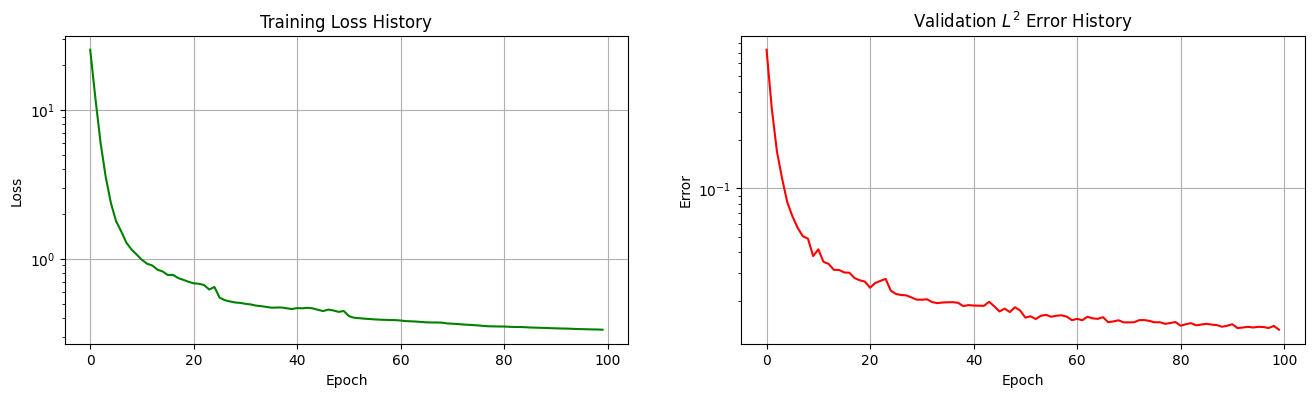

In [7]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
#

axes[0].semilogy(loss_list, color = 'green')
axes[0].set_title('Training Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

#
axes[1].semilogy(error_history, color = 'red')
axes[1].set_title('Validation $L^2$ Error History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Error')
axes[1].grid(True)
#
plt.show()

# 7) Showing $N$ Examples of Results

AXT shape:  torch.Size([50, 128, 100, 3])
U_true shape:  torch.Size([50, 128, 100, 1])
U_pred shape:  torch.Size([50, 128, 100, 1])
U True PLot:  torch.Size([50, 128, 100])
U_pred plot shape:  torch.Size([50, 128, 100])


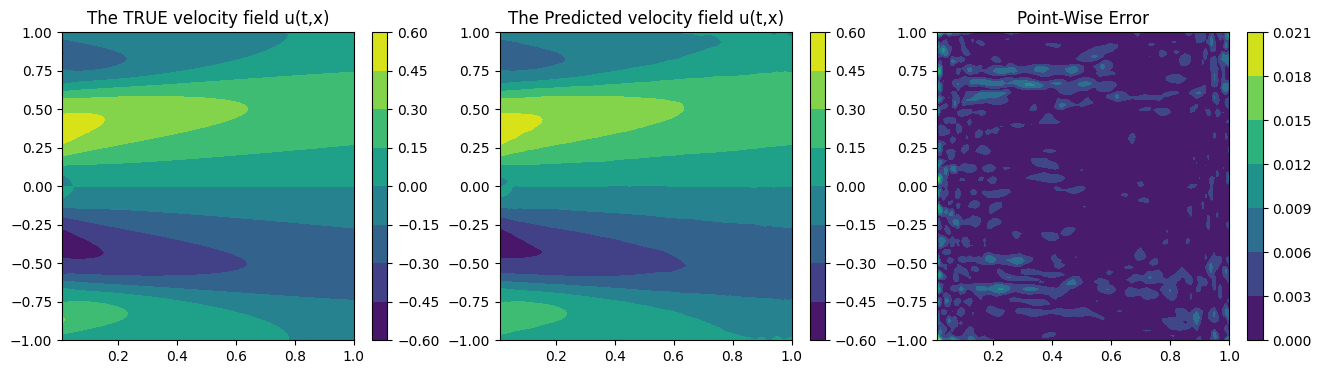

AXT shape:  torch.Size([50, 128, 100, 3])
U_true shape:  torch.Size([50, 128, 100, 1])
U_pred shape:  torch.Size([50, 128, 100, 1])
U True PLot:  torch.Size([50, 128, 100])
U_pred plot shape:  torch.Size([50, 128, 100])


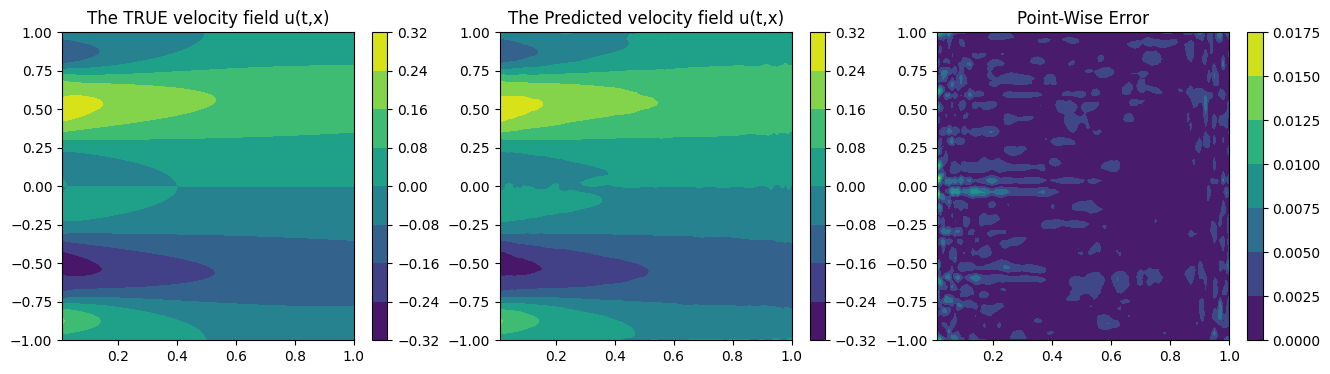

AXT shape:  torch.Size([50, 128, 100, 3])
U_true shape:  torch.Size([50, 128, 100, 1])
U_pred shape:  torch.Size([50, 128, 100, 1])
U True PLot:  torch.Size([50, 128, 100])
U_pred plot shape:  torch.Size([50, 128, 100])


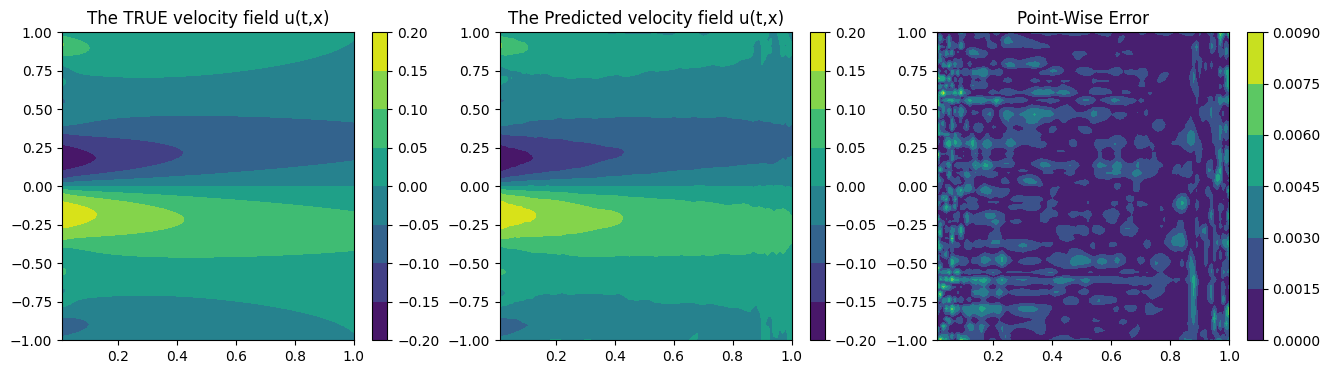

AXT shape:  torch.Size([50, 128, 100, 3])
U_true shape:  torch.Size([50, 128, 100, 1])
U_pred shape:  torch.Size([50, 128, 100, 1])
U True PLot:  torch.Size([50, 128, 100])
U_pred plot shape:  torch.Size([50, 128, 100])


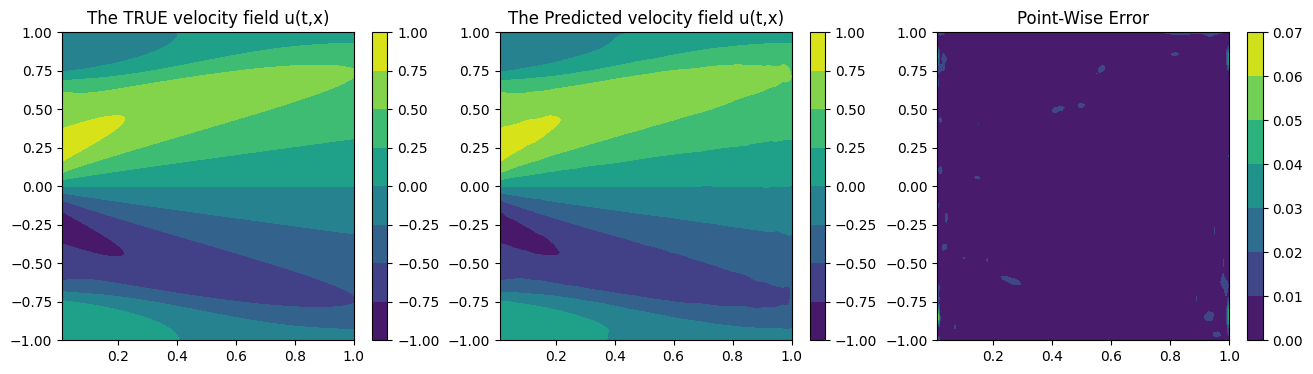

FNO2d(
  (activation): ReLU()
  (fc_in): Linear(in_features=3, out_features=20, bias=True)
  (spectral_conv): Sequential(
    (0): SpectralConv2d()
    (1): SpectralConv2d()
    (2): SpectralConv2d()
  )
  (weight_conv): Sequential(
    (0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
    (1): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
    (2): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  )
  (fc_out0): Linear(in_features=20, out_features=128, bias=True)
  (fc_out1): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
# Plot guessed fields for a few test samples
num_samples_to_plot = 5 # You can adjust this number

model_u.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for i, (axt_batch, u_batch) in enumerate(test_loader):
        if i >= num_samples_to_plot:
            break

        axt, u_true = axt_batch.to(device), u_batch.to(device)
        u_pred = model_u(axt)

        print("AXT shape: ", axt.shape) #[50, 100, 128, 3]
        print("U_true shape: ", u_true.shape) # [50, 100, 128]
        print("U_pred shape: ", u_pred.shape) # [50, 100, 128, 1]


        # if space comes first we have to reshape our u_true
        # as also reshape our meshgrid
        #u_true_plot = u_true.permute(0, 2, 1)
        u_true_plot = u_true.squeeze(-1)
        X, T = np.meshgrid(t_mesh.cpu(), x_mesh.cpu())

        # if times comes first then the u_true is already with the right dimensions
        #u_true_plot = u_true

        print("U True PLot: ", u_true_plot.shape) # [50, 128, 100]


        u_pred_plot = u_pred.squeeze()
        print("U_pred plot shape: ", u_pred_plot.shape) # [50, 100, 128]


        inx = i
        fig, axes = plt.subplots(1,3, figsize=(16,4))
        #

        cntr = axes[0].contourf(X, T, u_true_plot[inx].cpu())
        axes[0].set_title('The TRUE velocity field u(t,x)')
        plt.colorbar(cntr)
        #
        cntr = axes[1].contourf(X, T, u_pred_plot[inx].cpu())
        axes[1].set_title('The Predicted velocity field u(t,x)')
        plt.colorbar(cntr)
        #
        cntr = axes[2].contourf(X, T, torch.abs(u_true_plot[inx].cpu() - u_pred_plot[inx].cpu()))
        axes[2].set_title('Point-Wise Error')
        plt.colorbar(cntr)

        plt.show()


model_u.train() # Set the model back to training mode

# 8) Checking Results for First Instance of Testing

torch.Size([200, 128])


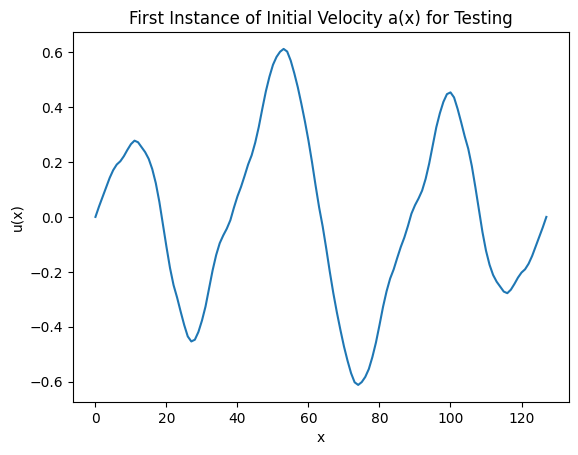

In [9]:
print(a_test.shape)
plt.plot(a_test[0].cpu())
plt.title('First Instance of Initial Velocity a(x) for Testing')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

torch.Size([1, 128, 100, 3])
torch.Size([128, 100])
torch.Size([128, 100])


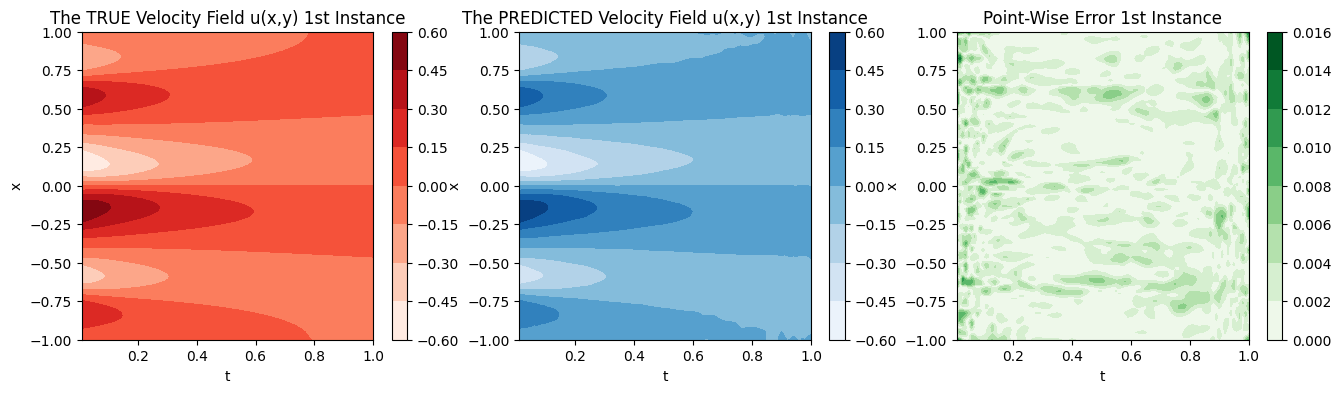

FNO2d(
  (activation): ReLU()
  (fc_in): Linear(in_features=3, out_features=20, bias=True)
  (spectral_conv): Sequential(
    (0): SpectralConv2d()
    (1): SpectralConv2d()
    (2): SpectralConv2d()
  )
  (weight_conv): Sequential(
    (0): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
    (1): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
    (2): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  )
  (fc_out0): Linear(in_features=20, out_features=128, bias=True)
  (fc_out1): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
model_u.eval()  # Set the model to evaluation mode

#first instances

axt_first = ax_t_test[0].to(device)
u_first = u_test[0].to(device)
u_first = u_first.permute(1, 0)



with torch.no_grad():

    axt_first = axt_first.unsqueeze(0)
    print(axt_first.shape)

    u_pred_first = model_u(axt_first)
    u_pred_first = u_pred_first.squeeze(0).squeeze(-1)
    print(u_pred_first.shape)
    print(u_first.shape)

    fig, axes = plt.subplots(1,3, figsize=(16,4))
    #

    cntr = axes[0].contourf(X, T, u_first.cpu(), cmap = 'Reds')
    axes[0].set_title('The TRUE Velocity Field u(x,y) 1st Instance')
    axes[0].set_xlabel('t')
    axes[0].set_ylabel('x')
    plt.colorbar(cntr)
    #
    cntr = axes[1].contourf(X, T, u_pred_first.cpu(), cmap = 'Blues')
    axes[1].set_title('The PREDICTED Velocity Field u(x,y) 1st Instance')
    axes[1].set_xlabel('t')
    axes[1].set_ylabel('x')
    plt.colorbar(cntr)
    #
    cntr = axes[2].contourf(X, T, torch.abs(u_first.cpu() - u_pred_first.cpu()),  cmap = 'Greens')
    axes[2].set_title('Point-Wise Error 1st Instance')
    axes[2].set_xlabel('t')
    axes[2].set_ylabel('x')
    plt.colorbar(cntr)

    plt.show()


model_u.train() # Set the model back to training mode